# Notebook analysing the band model script

In [2]:
%autoreload 1

In [3]:
%aimport band_model.utils.absorption
%aimport band_model.utils.utilities
from band_model import qd_base_data as qbd
from band_model.utils import absorption as ab
from band_model.utils import utilities as utils
from band_model.utils.absorption import envolute_matrix_element as eme
from band_model.utils.absorption import avg_trn_elements as ate
from band_model.pso.pso import particle_swarm

from scipy import special
import scipy.constants as scc
import scipy.integrate as sci
import scipy.interpolate as scin

import matplotlib.pyplot as plt
import matplotlib.cm as cmb
import seaborn as sns

import math
import numpy as np
import pandas as pd

import h5py
import importlib

from itertools import product
from pyevtk.hl import gridToVTK

import warnings
warnings.filterwarnings('ignore')

import time
import logging
logging.basicConfig(filename="output.log",
                    format='%(asctime)s - [%(levelname)s]:%(name)s[%(funcName)s]: %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("band_model").setLevel(logging.INFO)

## Calculating the normalized envolutes

In [3]:
qd_wavefunction = qbd.qd_results(3, 1.9, 0.08, 0.08, "CB1")

/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:67: RuntimeWarning: divide by zero encountered in true_divide
  f_E = 1.0 / np.tan(arg_cot) + np.sqrt(-(m2 / m1) * (energy /
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:72: RuntimeWarning: divide by zero encountered in true_divide
  j_term = special.spherical_jn(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:74: RuntimeWarning: divide by zero encountered in true_divide
  h_term = np.sqrt(-(m2 / m1) * (energy / (energy + V0))) * np.real(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:72: RuntimeWarning: invalid value encountered in true_divide
  j_term = special.spherical_jn(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:192: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(
/home/cemop/Documents/Python/Miguel/PhD/b

In [4]:
qd_wavefunction.e_levels

,l0,l1,l2,l3
0,-1.520441,-1.131609,-0.653472,-0.105484
1,-0.455799,NaN,NaN,NaN


### Check wavefunction from the normal calculation

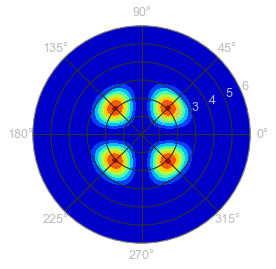

In [5]:
#angular momentum value
l = 2
#index of the energy level
k = 0
#z angular momentum
m = 1

#Calculate the radial part of the wavefunction
r,f_r = qd_wavefunction.norm_radial_wavefunction(l,k)
phi = np.linspace(0,2*np.pi,100)
#Angular part of the wavefunction
y_lm = np.absolute(special.sph_harm(m,l,0,phi))**2
#Combine both radial and angular parts
psi = np.array([y_lm*f_r_i for f_r_i in f_r])

#actual plotting
ax = plt.subplot(111, polar=True)
ctf = ax.contourf(phi,r,psi, cmap=cm.jet)

### Check for the 3D Cartesian plot Results

Normalization
0.9967307027571376


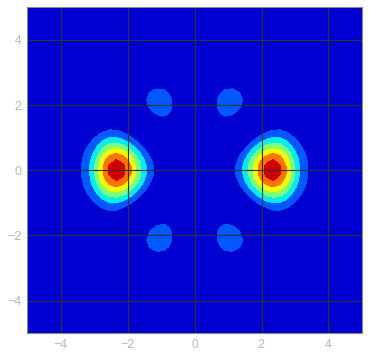

In [6]:
# l/m/n values
l = 3
m = 0
n = 0
n_points = 50
x = np.linspace(-5, 5, n_points)
y = np.linspace(-5, 5, n_points)
z = np.linspace(-5, 5, n_points)
XX, YY, ZZ, norm_wavefunction = qd_wavefunction.norm_wavefunction(x, y, z, l, m, n)
print("Normalization")
print(np.sum(np.abs(norm_wavefunction)**2)*(x[1]-x[0])**3)
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(XX[:, :, int(n_points/2)], ZZ[int(n_points/2)].T, np.abs(norm_wavefunction[:, int(n_points/2), :])**2, cmap=cm.jet)
plt.show()
# Export Results
exp_data = {"X": XX.flatten(), "Y": YY.flatten(), "Z": ZZ.flatten(), "env": (np.abs(norm_wavefunction)**2).flatten()}
exp_df = pd.DataFrame(exp_data)
exp_df.to_csv(f"wavefunction_{l}_{m}_{n}.csv", index=False)

### Calculate envolute

In [3]:
XX_env, YY_env, ZZ_env, envolute, t_matrix = qd_wavefunction.norm_envolute(10, 0.2, "L6mb", 0, 0, 1, 2.5, (1e-25, 1e-25))

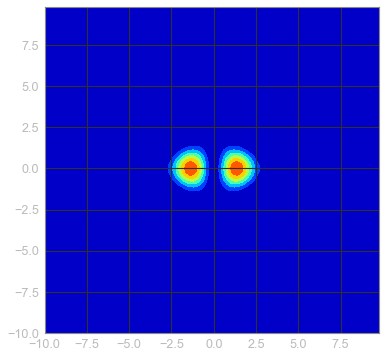

In [4]:
# l/m/n values
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(XX_env[:, :, 50], ZZ_env[50].T, np.abs(envolute[:, 50])**2, cmap=cm.jet)
plt.show()

### Check envolute normalization for all bands (CB1, CB2, VB1, VB2)

In [6]:
# Setup parameters
sim_size = 10
lat_size = 0.2
l = 2
m = 1
n = 0
Eg = 2.2
P = (1e-25, 1e-25)
# Guarantee normalization for the CB
qd_wavefunction_cb = qbd.qd_results(3, 1.9, 0.08, 0.08, "CB1")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)
envolutes_cb = [envolute_S, envolute_Y, envolute_X, envolute_Z]
norm_factor = 0
for envolute in envolutes_cb:
    norm_factor += np.sum(np.abs(envolute)**2)*(lat_size)**3
print("CB1 Normalization\n", norm_factor)

# Normalization for Light Holes
norm_factor = 0
qd_wavefunction_lh = qbd.qd_results(3, 1.9, 0.08, 0.08, "CB2")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)
envolutes_lh = [envolute_S, envolute_Y, envolute_X, envolute_Z]
norm_factor = 0
for envolute in envolutes_lh:
    norm_factor += np.sum(np.abs(envolute)**2)*(lat_size)**3
print("CB2 Normalization\n", norm_factor)

# Normalization for Heavy Holes
norm_factor = 0
qd_wavefunction_hh = qbd.qd_results(3, 1.9, 0.08, 0.08, "VB1")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)
envolutes_hh = [envolute_S, envolute_Y, envolute_X, envolute_Z]
norm_factor = 0
for envolute in envolutes_hh:
    norm_factor += np.sum(np.abs(envolute)**2)*(lat_size)**3
print("VB1 Normalization\n", norm_factor)

norm_factor = 0
qd_wavefunction_so = qbd.qd_results(3, 1.9, 0.08, 0.08, "VB2")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction_cb.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)
envolutes_so = [envolute_S, envolute_Y, envolute_X, envolute_Z]
norm_factor = 0
for envolute in envolutes_so:
    norm_factor += np.sum(np.abs(envolute)**2)*(lat_size)**3
print("VB2 Normalization\n", norm_factor)

CB1 Normalization
 0.9999977420365855
CB2 Normalization
 0.9999977420365855
VB1 Normalization
 0.9999977420365855
VB2 Normalization
 0.9999977420365855


## Visualizing envolutes

In [7]:
# Setup parameters
sim_size = 10
lat_size = 0.15
l = 2
m = 0
n = 0
Eg = 1.42
P = (1e-25, 1e-25)
center = int(sim_size/lat_size/2)
print(center)

33


For the conduction band 1

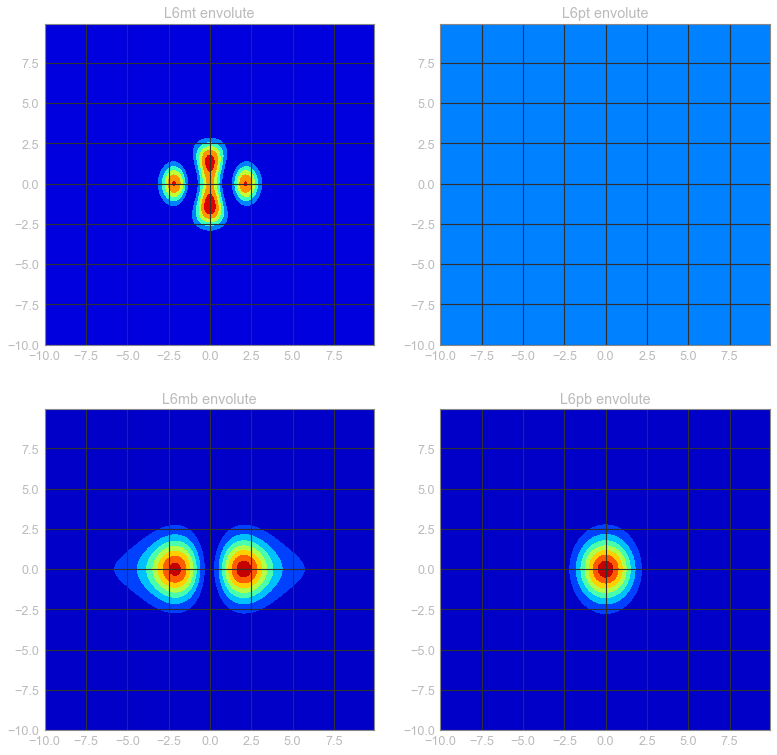

In [8]:
# Guarantee normalization for the CB
qd_wavefunction = qbd.qd_results(3, 1.9, 0.08, 0.08, "CB1")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)

fig, ax = plt.subplots(figsize=(13, 13), ncols=2, nrows=2)
ax[0, 0].contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[:, center, :])**2, cmap=cm.jet)
ax[0, 0].set_title("L6mt envolute")
ax[1, 0].contourf(XX_env_Y[:, :, center], ZZ_env_Y[center].T, np.abs(envolute_Y[:, center, :])**2, cmap=cm.jet)
ax[1, 0].set_title("L6mb envolute")
ax[0, 1].contourf(XX_env_X[:, :, center], ZZ_env_X[center].T, np.abs(envolute_X[:, center, :])**2, cmap=cm.jet)
ax[0, 1].set_title("L6pt envolute")
ax[1, 1].contourf(XX_env_Z[:, :, center], ZZ_env_Z[center].T, np.abs(envolute_Z[:, center, :])**2, cmap=cm.jet)
ax[1, 1].set_title("L6pb envolute")
plt.show()

For the CB 2

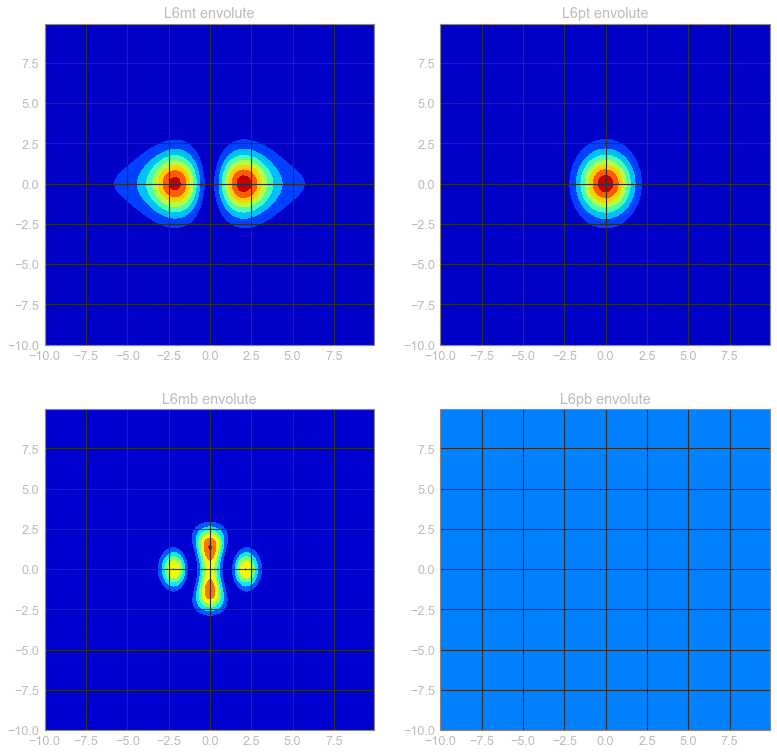

In [9]:
# Guarantee normalization for the CB
qd_wavefunction = qbd.qd_results(3, 1.9, 0.08, 0.08, "CB2")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)

fig, ax = plt.subplots(figsize=(13, 13), ncols=2, nrows=2)
ax[0, 0].contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[:, center, :])**2, cmap=cm.jet)
ax[0, 0].set_title("L6mt envolute")
ax[1, 0].contourf(XX_env_Y[:, :, center], ZZ_env_Y[center].T, np.abs(envolute_Y[:, center, :])**2, cmap=cm.jet)
ax[1, 0].set_title("L6mb envolute")
ax[0, 1].contourf(XX_env_X[:, :, center], ZZ_env_X[center].T, np.abs(envolute_X[:, center, :])**2, cmap=cm.jet)
ax[0, 1].set_title("L6pt envolute")
ax[1, 1].contourf(XX_env_Z[:, :, center], ZZ_env_Z[center].T, np.abs(envolute_Z[:, center, :])**2, cmap=cm.jet)
ax[1, 1].set_title("L6pb envolute")
plt.show()

For the VB1 band

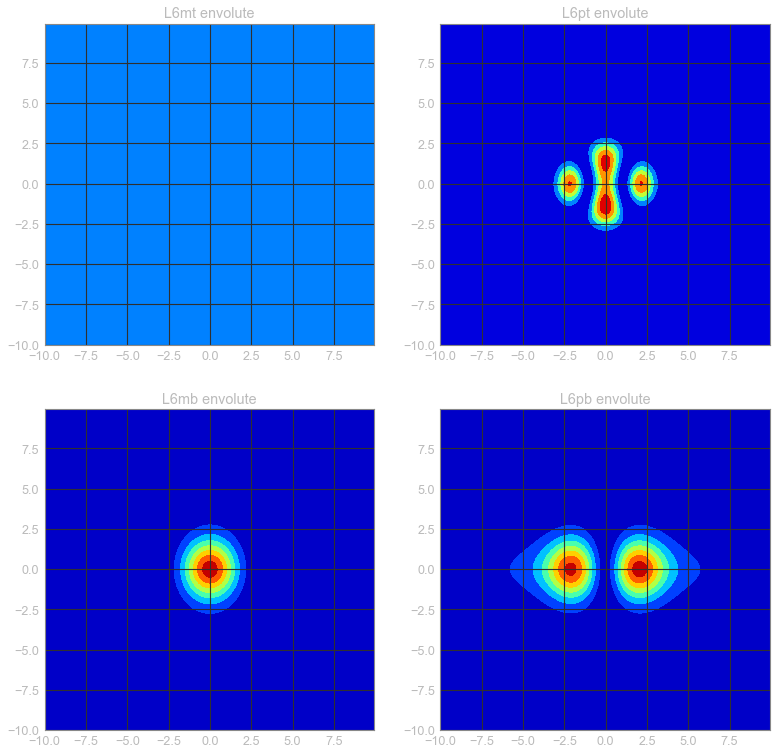

In [10]:
# Guarantee normalization for the CB
qd_wavefunction = qbd.qd_results(3, 1.9, 0.08, 0.08, "VB1")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)

fig, ax = plt.subplots(figsize=(13, 13), ncols=2, nrows=2)
ax[0, 0].contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[:, center, :])**2, cmap=cm.jet)
ax[0, 0].set_title("L6mt envolute")
ax[1, 0].contourf(XX_env_Y[:, :, center], ZZ_env_Y[center].T, np.abs(envolute_Y[:, center, :])**2, cmap=cm.jet)
ax[1, 0].set_title("L6mb envolute")
ax[0, 1].contourf(XX_env_X[:, :, center], ZZ_env_X[center].T, np.abs(envolute_X[:, center, :])**2, cmap=cm.jet)
ax[0, 1].set_title("L6pt envolute")
ax[1, 1].contourf(XX_env_Z[:, :, center], ZZ_env_Z[center].T, np.abs(envolute_Z[:, center, :])**2, cmap=cm.jet)
ax[1, 1].set_title("L6pb envolute")
plt.show()

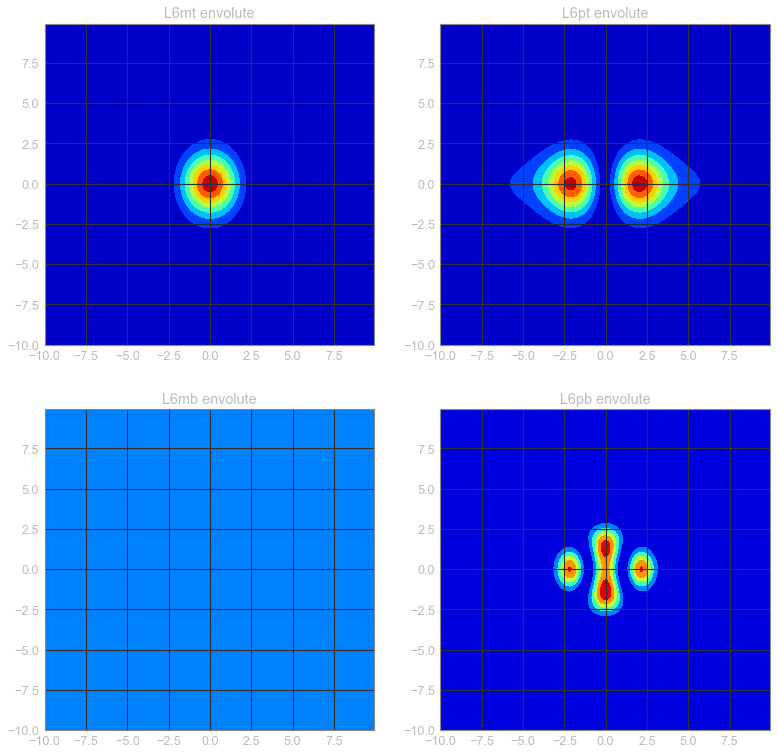

In [11]:
# Guarantee normalization for the CB
qd_wavefunction = qbd.qd_results(3, 1.9, 0.08, 0.08, "VB2")
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mt", l, m, n, Eg, P)
XX_env_Y, YY_env_Y, ZZ_env_Y, envolute_Y, t_matrix_Y = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6mb", l, m, n, Eg, P)
XX_env_X, YY_env_X, ZZ_env_X, envolute_X, t_matrix_X = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pt", l, m, n, Eg, P)
XX_env_Z, YY_env_Z, ZZ_env_Z, envolute_Z, t_matrix_Z = qd_wavefunction.norm_envolute(sim_size, lat_size, "L6pb", l, m, n, Eg, P)

fig, ax = plt.subplots(figsize=(13, 13), ncols=2, nrows=2)
ax[0, 0].contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[:, center, :])**2, cmap=cm.jet)
ax[0, 0].set_title("L6mt envolute")
ax[1, 0].contourf(XX_env_Y[:, :, center], ZZ_env_Y[center].T, np.abs(envolute_Y[:, center, :])**2, cmap=cm.jet)
ax[1, 0].set_title("L6mb envolute")
ax[0, 1].contourf(XX_env_X[:, :, center], ZZ_env_X[center].T, np.abs(envolute_X[:, center, :])**2, cmap=cm.jet)
ax[0, 1].set_title("L6pt envolute")
ax[1, 1].contourf(XX_env_Z[:, :, center], ZZ_env_Z[center].T, np.abs(envolute_Z[:, center, :])**2, cmap=cm.jet)
ax[1, 1].set_title("L6pb envolute")
plt.show()

## Visualization testing

25


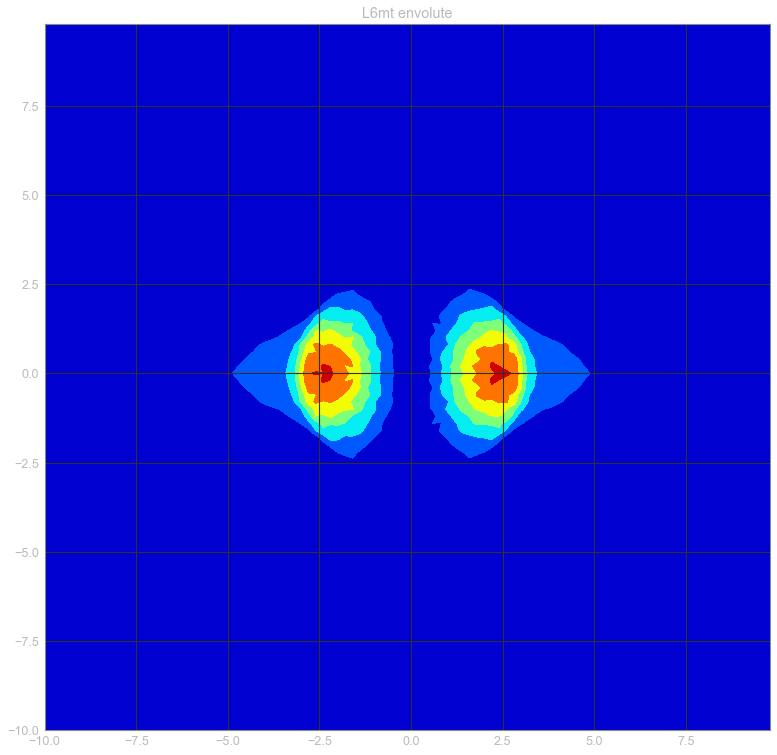

'/home/miguel/Documents/Python/PhD/Article_2_Results/band_VB1_envolute_L6pb_0_0_0.vtr'

In [21]:
sim_size = 10
lat_size = 0.2
l = 0
m = 0
n = 0
Eg = 0.4
P = (1e-25, 1e-25)
env = "L6pb"
band = "VB1"
center = int(sim_size/lat_size/2)
print(center)
qd_wavefunction = qbd.qd_results(3, 1, 0.08, 0.08, band)
XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, env, l, m, n, Eg, P)
fig, ax = plt.subplots(figsize=(13, 13))
ax.contourf(XX_env_S[:, :, center], ZZ_env_S[center].T, np.abs(envolute_S[10])**2, cmap=cm.jet)
ax.set_title("L6mt envolute")
plt.show()
# exp_data = {"X": XX_env_S.flatten(), "Y": YY_env_S.flatten(), "Z": ZZ_env_S.flatten(), "env": (np.abs(envolute_S)**2).flatten()}
# exp_df = pd.DataFrame(exp_data)
# exp_df.to_csv(f"{env}_envolute_{l}_{m}_{n}_{band}.csv", index=False)
x = np.arange(-sim_size, sim_size, lat_size)
gridToVTK(f"Article_2_Results/band_{band}_envolute_{env}_{l}_{m}_{n}", x, x, x, pointData = {'QD': np.abs(envolute_S)**2})

# Calculation of the Absorption Coefficients

### Determine the matrix elements

The dipole matrix ruling the photon-electron interaction is given by

\begin{equation}
\langle \Theta | \epsilon \cdot r | \Theta' \rangle \approx \langle \Psi_S | \epsilon \cdot r | \Psi_S' \rangle + \langle \Psi_X | \epsilon \cdot r | \Psi_X' \rangle + \langle \Psi_Y | \epsilon \cdot r | \Psi_Y' \rangle + \langle \Psi_Z | \epsilon \cdot r | \Psi_Z' \rangle
\end{equation}

This equation uses the integral factorization rule and the orthonormal properties of GBFs.

From here it is possible to define the polarization via its Euler angles ($\theta, \phi$)
\begin{equation}
\langle\Theta |\epsilon\cdot r|\Theta'\rangle = cos(\phi)sin(\theta)\langle \Theta|x|\Theta'\rangle + sin(\phi)sin(\theta)\langle\Theta|y|\Theta'\rangle + cos(\theta)\langle\Theta|z|\Theta'\rangle
\end{equation}

For this first case I will consider vertical unpolarized radiation such that the above equation is $\phi$ integrated (between [0, 2$\pi$]) and $\theta$ is defined as 2$\pi$, resulting in

\begin{equation}
\langle\Theta |\epsilon\cdot r|\Theta'\rangle = ( \langle\Theta|x|\Theta'\rangle + \langle\Theta|y|\Theta'\rangle ) / 2
\end{equation}

Code implemented in the band_model module

```python
def envolute_matrix_element(qd_i, e_i, qd_f, e_f, sim_properties):
    """
    Determines the envolute matrix elements between qd_1 and qd_2
    """
    # assert qd_i.band != qd_f.band, "Bands should be different"
    envolutes = ["L6mt", "L6mb", "L6pt", "L6pb"]
    sim_size, lat_size, Eg, P = sim_properties
    ni, li = e_i
    nf, lf = e_f
    Mx_array = []
    My_array = []
    Mz_array = []
    # Define the iterator from the input values
    if li != 0 and lf != 0:
        iterator = product(range(-li, li + 1), range(-lf, lf + 1))
    elif li == 0 and lf != 0:
        iterator = product([0], range(-lf, lf + 1))
    elif li != 0 and lf == 0:
        iterator = product(range(-li, li + 1), [0])
    else:
        iterator = zip([0], [0])
    # Loop through all possible m value combinations
    for m_i_i, m_f_i in iterator:
        # print("Calculating....")
        # print(m_i_i, m_f_i)
        # Calculate the matrix element for transition between 2 elements (for a specific m value)
        # This element is determined from the sum of the elements from the 4 envolutes
        Mx, My, Mz = 0, 0, 0
        for envolute in envolutes:
            XX, YY, ZZ, env_i, _ = qd_i.norm_envolute(sim_size, lat_size, envolute, li, m_i_i, ni, Eg, P)
            _, _, _, env_f, _ = qd_f.norm_envolute(sim_size, lat_size, envolute, lf, m_f_i, nf, Eg, P)
            # Function integration
            Mx += np.sum(env_i * XX * np.conjugate(env_f)) * lat_size ** 3
            My += np.sum(env_i * YY * np.conjugate(env_f)) * lat_size ** 3
            Mz += np.sum(env_i * ZZ * np.conjugate(env_f)) * lat_size ** 3
        # Determine the matrix element from n1, l1, m1 to n2, l2, m2
        Mx_array.append(np.abs(Mx))
        My_array.append(np.abs(My))
        Mz_array.append(np.abs(Mz))
    # Put all Mx/My/Mz values under 1e-7 to 0
    Mx_array = np.array(Mx_array)
    My_array = np.array(My_array)
    Mz_array = np.array(Mz_array)
    # print("Mx Values", Mx_array, "My_values", My_array, "Mz Values", Mz_array, sep="\n")
    # Obtain the mean of the non-zero values
    # Create a mask for the weigths
    mx_zeros = Mx_array > 10e-5
    my_zeros = My_array > 10e-5
    mz_zeros = Mz_array > 10e-5
    # Check if the mask does not sum to 0 and determine the average
    if True in mx_zeros:
        Mx_final = np.average(Mx_array, weights=mx_zeros)
    else:
        Mx_final = 0
    if True in my_zeros:
        My_final = np.average(My_array, weights=my_zeros)
    else:
        My_final = 0
    if True in mz_zeros:
        Mz_final = np.average(Mz_array, weights=mz_zeros)
    else:
        Mz_final = 0
    return Mx_final, My_final, Mz_final


p = 1e-25
qd_test_1 = qbd.qd_results(5, 1.1, 0.08, 0.08, "CB1")
qd_test_2 = qbd.qd_results(5, 0.6, 0.08, 0.08, "VB1")
envolute_matrix_element(qd_test_2, (0, 0), qd_test_1, (0, 2), (8, 0.2, 2.5, (p, p)))
```

Testing the magnitude of severall transitions

In [ ]:
sizes = np.linspace(1, 5, 5)
sim_properties = (10, 0.3, 2.3, (1e-25, 1e-25))
levels = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 2), (1, 3)]
for size in sizes:
    print("Calculation for size: ", size, "\n")
    qd1 = qbd.qd_results(size, 1.2, 0.08, 0.08, "VB1")
    if qd1.e_levels.empty:
        continue
    print("QD1 Energy Levels:")
    print(qd1.e_levels)
    qd2 = qbd.qd_results(size, 0.7, 0.1, 0.1, "CB1")
    if qd2.e_levels.empty:
        continue
    print("QD2 Energy Levels:")
    print(qd2.e_levels)
    print("\n")
    for state_lh, state_cb in product(levels, levels):
        try:
            Mx, My, Mz = ab.envolute_matrix_element(qd1, state_lh, qd2, state_cb, sim_properties)
            print("Calculating from:", state_lh, state_cb)
            print("Mx: ", Mx, "My: ", My, "Mz: ", Mz)
        except IndexError:
            continue

### Cicle through all present energy levels

Code implemented in the band_model module

```python
def interband_transition_elements(qd1, qd2, sim_properties):
    """
    Calculates all the interband transition elements between qd1 and qd2
    Returns:
        transition_list (list): List with the transition elements (Transition energy, (Mx, My, Mz))
    """
    # Create a list with all the present (n, l) level combinations for each qd
    qd1_e_values = qd1.e_levels.values
    qd1_levels = list(product(range(qd1_e_values.shape[0]), range(qd1_e_values.shape[1])))
    qd2_e_values = qd2.e_levels.values
    qd2_levels = list(product(range(qd2_e_values.shape[0]), range(qd2_e_values.shape[1])))
    transition_list = []
    # Cicle through all the (n, l) combination of both qds, coupled with each particular energy level
    for ((qd1_level, qd2_level), (qd1_energy, qd2_energy)) in zip(
        product(qd1_levels, qd2_levels), 
        product(qd1_e_values.flatten(), qd2_e_values.flatten())):
        # Ignore all combinations where either the energy of qd1 or qd2 is nan
        if math.isnan(qd1_energy) or math.isnan(qd2_energy):
            continue
        transition_list.append((sim_properties[2] + qd1_energy + qd2_energy,
                                eme(qd1, qd1_level, qd2, qd2_level, sim_properties)))
    return transition_list
```

Update to the absorption_ij script to ignore the calculation of the qd_density, thus calculating the absorption per coefficient density

```python
def absorption_ij(energy,
                  t_energy,
                  matrix_elements,
                  gauss_dispersion=0.025,
                  n_index=2.5):
    """Gaussian absorption density profile for energy transition from an initial to a
    final state
    Args:
        energy (array): Base array [eV]
        t_energy (double): Transition energy (energy difference between the
                            initial and final states) [eV]
        gauss_dispersion (double): Dispersion value for the Gaussian profile
                            (default - 0.025 eV)
        matrix_elements (tuple): Matrix elements for the different
                            polarizations [nm]
        qd_density (tuple): Linear qd density for the 3 different dimensions
                        (default - (1/50nm, 1/50nm, 1/50nm)) [nm-1]
        n_index (array): Refractive index array - should be the same shape
                        as the energy or single valued (default = 2)
    Returns:
        abs_ij (array): Absorption density for the transition i->j [cm-1nm-3]
    """
    # Initialize necessary constants
    # C, J.s, m/s, C^2/(N.m^2) the powers cut in the fraction
    q, h, c, e0 = 1.6022, 6.626, 2.9979, 8.8542
    # Calculate the fraction responsible for the units
    constant_fraction = ((2 * np.pi**2 * q**2 * energy) /
                         (n_index * c * h * e0))
    # Approximate the delta function
    delta = (1 / (np.sqrt(np.pi) * gauss_dispersion)) * \
        np.exp(-((energy - t_energy) / gauss_dispersion)
               ** 2)
    # Calculate absorption coefficient
    # The 1e7 normalizes the units to nm3/cm
    abs_ij = 2 * matrix_elements**2 * constant_fraction * \
        delta * 1e7
    return abs_ij
```

Calculate the absorption coefficient per density for a QD with specific properties
(does not take into account polarization - simply uses the Mz component for the calculation)

/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:67: RuntimeWarning: divide by zero encountered in true_divide
  f_E = 1.0 / np.tan(arg_cot) + np.sqrt(-(m2 / m1) * (energy /
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:72: RuntimeWarning: divide by zero encountered in true_divide
  j_term = special.spherical_jn(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:74: RuntimeWarning: divide by zero encountered in true_divide
  h_term = np.sqrt(-(m2 / m1) * (energy / (energy + V0))) * np.real(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:72: RuntimeWarning: invalid value encountered in true_divide
  j_term = special.spherical_jn(
/home/cemop/Documents/Python/Miguel/PhD/band_model/qd_base_data.py:192: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(
/home/cemop/Documents/Python/Miguel/PhD/b

         l0        l1       l2       l3
0 -0.982689 -0.759327 -0.48327 -0.16309
1 -0.364990 -0.011186      NaN      NaN
         l0        l1        l2
0 -0.501797 -0.302648 -0.066993
1 -0.008217       NaN       NaN
Transition from  (0, 0) to  (0, 0)
Transition from  (0, 0) to  (0, 1)
Transition from  (0, 0) to  (0, 2)
Transition from  (0, 0) to  (1, 0)
Transition from  (0, 1) to  (0, 0)
Transition from  (0, 1) to  (0, 1)
Transition from  (0, 1) to  (0, 2)
Transition from  (0, 1) to  (1, 0)
Transition from  (0, 2) to  (0, 0)
Transition from  (0, 2) to  (0, 1)
Transition from  (0, 2) to  (0, 2)
Transition from  (0, 2) to  (1, 0)
Transition from  (0, 3) to  (0, 0)
Transition from  (0, 3) to  (0, 1)
Transition from  (0, 3) to  (0, 2)
Transition from  (0, 3) to  (1, 0)
Transition from  (1, 0) to  (0, 0)
Transition from  (1, 0) to  (0, 1)
Transition from  (1, 0) to  (0, 2)
Transition from  (1, 0) to  (1, 0)
Transition from  (1, 1) to  (0, 0)
Transition from  (1, 1) to  (0, 1)
Transition fro

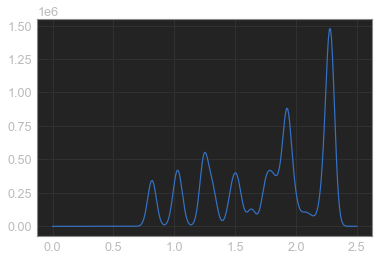

In [7]:
qd1 = qbd.qd_results(4, 1.2, 0.08, 0.08, "CB1")
qd2 = qbd.qd_results(4, 0.7, 0.08, 0.08, "VB1")
sim_properties = (20, 0.4, 2.3, (2e-25, 1e-25))
print(qd1.e_levels)
print(qd2.e_levels)
energy = np.linspace(0, 2.5, 300)
absorption = np.zeros_like(energy)
transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
for transition in transitions:
    t_energy = transition[0]
    matrix_element = transition[1][2]
    absorption += ab.absorption_ij(energy, t_energy, matrix_element, gauss_dispersion=0.05)
    
plt.plot(energy, absorption)

### Check transitions for different band combinations

The properties of used from here on

me-PbS = 0.08 me

mh-PbS = 0.08 me

Pt = 4.7e-25 Kg m/s[Kang]

Pl = 3.4e-25 Kg m/s [Kang]

Eg (if needed) = 2.3 eV

Eg-PbS = 0.4 eV

Vcb and Vvb are equal


I considered ml = mt (the values are relatively close to each other - 0.08 to 0.105 with errors around 0.015 [Dalven 1974])

In [33]:
me = 0.08
mh = 0.08
Pt = 4.7e-25
Pl = 3.4e-25
size = 4
Eg = 2.3
sim_properties = (10, 0.15, Eg, (Pl, Pt))
qdcb1 = qbd.qd_results(size, 0.85, me, me, "CB1")
qdcb2 = qbd.qd_results(size, 0.85, me, me, "CB2")
qdvb1 = qbd.qd_results(size, 0.85, mh, mh, "VB1")
qdvb2 = qbd.qd_results(size, 0.85, mh, mh, "VB2")
print(qdcb1.e_levels)
print(qdcb2.e_levels)
print(qdvb1.e_levels)
print(qdvb2.e_levels)

/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:67: RuntimeWarning: divide by zero encountered in true_divide
  f_E = 1.0 / np.tan(arg_cot) + np.sqrt(-(m2 / m1) * (energy /
/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:72: RuntimeWarning: divide by zero encountered in true_divide
  j_term = special.spherical_jn(
/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:74: RuntimeWarning: divide by zero encountered in true_divide
  h_term = np.sqrt(-(m2 / m1) * (energy / (energy + V0))) * np.real(
/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:72: RuntimeWarning: invalid value encountered in true_divide
  j_term = special.spherical_jn(
/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:192: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(
/home/miguel/Documents/Python/PhD/band_model/qd_base_data.py:198: Integ

         l0        l1        l2
0 -0.644501 -0.435817 -0.183076
1 -0.091767       NaN       NaN
         l0        l1        l2
0 -0.644501 -0.435817 -0.183076
1 -0.091767       NaN       NaN
         l0        l1        l2
0 -0.644501 -0.435817 -0.183076
1 -0.091767       NaN       NaN
         l0        l1        l2
0 -0.644501 -0.435817 -0.183076
1 -0.091767       NaN       NaN


In [34]:
e_i = (0, 0)
e_f = (0, 0)
dummy = ab.envolute_matrix_element(qdcb1, e_i, qdvb1, e_f, sim_properties)
print("CB1 → VB1: ", dummy)
dummy = ab.envolute_matrix_element(qdcb1, e_i, qdvb2, e_f, sim_properties)
print("CB1 → VB2: ", dummy)
dummy = ab.envolute_matrix_element(qdcb2, e_i, qdvb1, e_f, sim_properties)
print("CB2 → VB1: ", dummy)
dummy = ab.envolute_matrix_element(qdcb2, e_i, qdvb2, e_f, sim_properties)
print("CB2 → VB2: ", dummy)

CB1 → VB1:  (0, 0, 0.07595954994639179)
CB1 → VB2:  (0.10609489540627426, 0, 0)
CB2 → VB1:  (0.10612760830256131, 0.10612760830256128, 0)
CB2 → VB2:  (0, 0, 0.07595954994639179)


# Article Results

The properties of used from here on:

|me-Pbs|mh-PbS|Pt[Kang]|Pl[Kang]|Eg-Psk|Eg-PbS|Vcb|Vvb|
|------|------|--|--|------|------|---|---|
|0.08|0.08|4.7e-25|3.4e-25|2.3|0.4|0.4|1.5|


I considered ml = mt (the values are relatively close to each other - 0.08 to 0.105 with errors around 0.015 [Dalven 1974])

The value for Vcb was determined by aligning the Electron Affinity levels for both perovskite with 2.3 eV [Tao 2019] and PbS [Gokalinska 2010] (4.6 - 4.2 = 0.4).
The value for Vvb is obtained from the difference between the bandgap and Vcb

## Convergence tests for calculating the M values

Determine the Mx, My and Mz values with the variation of several parameters.

This study is similar to the convergence test, where the objective is to see the ideal spot to do the simulations (lattice size and simulation size-wise)

The several studies included here:

- QSize vs Num Elevels - To check for QSize boundaries
- Potential barrier vs Num Elevels - To check for Potential barrier boundaries

Note: The following studies are made for all the interband transitions and for the first 2 transitions

- Lattice size vs Mx, My, Mz (for all the different parameters) [0.4:1.5] nm
- Simulation size vs Mx, My, Mz (for all the different parameters) [10:30] nm
- Execution time with increased lattice size and simulation size

In [5]:
dir_prefix = "Article_2_Results"
def update_step(it_num, total_it):
    """Helper function to print the iteration number
    in a for loop"""
    if it_num == total_it:
        print(f"\rIteration {it_num:04d}/{total_it:04d}")
    else:
        print(f"\rIteration {it_num:04d}/{total_it:04d}", end="")
    pass

### QSize vs Num Elevels / Barrier vs Num Elevels

In [16]:
# Calculate number of energy levels for different QD size
# and different potential Barriers
# This serves to define the default QDSize and the buffer size
# for the potential barrier for later use
n_size = 150
v_size = 150
qd_size = np.linspace(0.5, 10, n_size)
Vcb = np.linspace(0.1, 2.3, v_size)
me = 0.08
band = "CB1"
it = 0
n_levels = list()
for qd_size_i, V_i in product(qd_size, Vcb):
    it += 1
    update_step(it, n_size*v_size)
    qd1 = qbd.qd_results(qd_size_i, V_i, me, me, band)
    n_levels.append(np.isfinite(qd1.e_levels.values).sum())

n_levels = np.array(n_levels).reshape(n_size, v_size)
export_file = f"{dir_prefix}/QSize_PBarrier_NLevels_CB1.csv"
df = pd.DataFrame(n_levels, columns=Vcb, index=qd_size).to_csv(export_file, sep=" ")

Iteration 22500/22500

### Lattice size vs Mx, My, Mz

In [3]:
# Define the constant variables
# Default values
# me = 0.08
# mh = 0.08
# Pt = 4.7e-25
# Pl = 3.4e-25
# qd_size = 3
# Eg = 2.3
# Vcb = 0.4
# Vvb = 1.5
# sim_size = 10
# band_i = "VB1"
# band_f = "CB1"
# lat_size = np.linspace(0.4, 2, 2)
n_lat = 50; n_param = 5
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; sim_size = 10
Eg = 2.3
Vcb = 0.4;
Vvb = 1.5
band_i = "VB1"
band_f = "CB1"
transition = 0
lat_size = np.linspace(0.4, 2, n_lat)
export_name = lambda name: f"Article_2_Results/{name}_{band_i}_{band_f}.csv"

run_i = 0
m_values = list()
param = np.linspace(1e-25, 1e-24, n_param)
column_vals = [f"{point:.2g}" for point in param]
print("Running for Pl")
for Pl in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for lat_size_i in lat_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)
        sim_properties = (sim_size, lat_size_i, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))

exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=column_vals, index=lat_size).to_csv(export_name("Mx_LSize_Pl"), sep=" ")
pd.DataFrame(My, columns=column_vals, index=lat_size).to_csv(export_name("My_LSize_Pl"), sep=" ")
pd.DataFrame(Mz, columns=column_vals, index=lat_size).to_csv(export_name("Mz_LSize_Pl"), sep=" ")
pd.DataFrame(exec_time, columns=column_vals, index=lat_size).to_csv(export_name("ETime_LSize_Pl"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=lat_size).to_csv(export_name("NTrn_LSize_Pl"), sep=" ")

me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; sim_size = 10
run_i = 0
m_values = list()
param = np.linspace(1e-25, 1e-24, n_param)
column_vals = [f"{point:.2g}" for point in param]
print("Running for Pt")
for Pt in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for lat_size_i in lat_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)  
        sim_properties = (sim_size, lat_size_i, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))
    
exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=column_vals, index=lat_size).to_csv(export_name("Mx_LSize_Pt"), sep=" ")
pd.DataFrame(My, columns=column_vals, index=lat_size).to_csv(export_name("My_LSize_Pt"), sep=" ")
pd.DataFrame(Mz, columns=column_vals, index=lat_size).to_csv(export_name("Mz_LSize_Pt"), sep=" ")
pd.DataFrame(exec_time, columns=column_vals, index=lat_size).to_csv(export_name("ETime_LSize_Pt"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=lat_size).to_csv(export_name("NTrn_LSize_Pt"), sep=" ")

me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; sim_size = 10
run_i = 0
m_values = list()
param = np.round(np.linspace(0.05, 0.15, n_param), 2)
print("Running for me")
for me in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for lat_size_i in lat_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)
        sim_properties = (sim_size, lat_size_i, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))
    
exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=param, index=lat_size).to_csv(export_name("Mx_LSize_me"), sep=" ")
pd.DataFrame(My, columns=param, index=lat_size).to_csv(export_name("My_LSize_me"), sep=" ")
pd.DataFrame(Mz, columns=param, index=lat_size).to_csv(export_name("Mz_LSize_me"), sep=" ")
pd.DataFrame(exec_time, columns=param, index=lat_size).to_csv(export_name("ETime_LSize_me"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=lat_size).to_csv(export_name("NTrn_LSize_me"), sep=" ")

me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; sim_size = 10
run_i = 0
m_values = list()
param = np.round(np.linspace(0.05, 0.15, n_param), 2)
print("Running for mh")
for mh in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for lat_size_i in lat_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)
        sim_properties = (sim_size, lat_size_i, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))
    
exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=param, index=lat_size).to_csv(export_name("Mx_LSize_mh"), sep=" ")
pd.DataFrame(My, columns=param, index=lat_size).to_csv(export_name("My_LSize_mh"), sep=" ")
pd.DataFrame(Mz, columns=param, index=lat_size).to_csv(export_name("Mz_LSize_mh"), sep=" ")
pd.DataFrame(exec_time, columns=param, index=lat_size).to_csv(export_name("ETime_LSize_mh"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=lat_size).to_csv(export_name("NTrn_LSize_mh"), sep=" ")

me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; sim_size = 10
run_i = 0
m_values = list()
param = np.round(np.linspace(2, 10, n_param), 1)
print("Running for QSize")
for qd_size in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for lat_size_i in lat_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)
        sim_properties = (sim_size, lat_size_i, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))
    
exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=param, index=lat_size).to_csv(export_name("Mx_LSize_QSize"), sep=" ")
pd.DataFrame(My, columns=param, index=lat_size).to_csv(export_name("My_LSize_QSize"), sep=" ")
pd.DataFrame(Mz, columns=param, index=lat_size).to_csv(export_name("Mz_LSize_QSize"), sep=" ")
pd.DataFrame(exec_time, columns=param, index=lat_size).to_csv(export_name("ETime_LSize_QSize"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=lat_size).to_csv(export_name("NTrn_LSize_QSize"), sep=" ")

me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; sim_size = 10
run_i = 0
m_values = list()
param = np.round(np.linspace(10, 30, n_param), 1)
print("Running for SSize")
for sim_size in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for lat_size_i in lat_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)
        sim_properties = (sim_size, lat_size_i, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))
    
exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=param, index=lat_size).to_csv(export_name("Mx_LSize_SSize"), sep=" ")
pd.DataFrame(My, columns=param, index=lat_size).to_csv(export_name("My_LSize_SSize"), sep=" ")
pd.DataFrame(Mz, columns=param, index=lat_size).to_csv(export_name("Mz_LSize_SSize"), sep=" ")
pd.DataFrame(exec_time, columns=param, index=lat_size).to_csv(export_name("ETime_LSize_SSize"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=lat_size).to_csv(export_name("NTrn_LSize_SSize"), sep=" ")

Running for Pl
Iteration 0250/0250
Running for Pt
Iteration 0250/0250
Running for me
Iteration 0250/0250
Running for mh
Iteration 0250/0250
Running for QSize
Iteration 0250/0250
Running for SSize
Iteration 0250/0250


### Simulation size vs M

In [4]:
n_lat = 50; n_param = 5
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8
Eg = 2.3
Vcb = 0.4;
Vvb = 1.5
band_i = "VB1"
band_f = "CB1"
transition = 0
sim_size = np.linspace(10, 25, n_lat)
export_name = lambda name: f"Article_2_Results/{name}_{band_i}_{band_f}.csv"

run_i = 0
m_values = list()
param = np.linspace(1e-25, 1e-24, n_param)
column_vals = [f"{point:.2g}" for point in param]
print("Running for Pl")
for Pl in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for sim_size_i in sim_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)
        sim_properties = (sim_size_i, lat_size, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))

exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=column_vals, index=sim_size).to_csv(export_name("Mx_SSize_Pl"), sep=" ")
pd.DataFrame(My, columns=column_vals, index=sim_size).to_csv(export_name("My_SSize_Pl"), sep=" ")
pd.DataFrame(Mz, columns=column_vals, index=sim_size).to_csv(export_name("Mz_SSize_Pl"), sep=" ")
pd.DataFrame(exec_time, columns=column_vals, index=sim_size).to_csv(export_name("ETime_SSize_Pl"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=sim_size).to_csv(export_name("NTrn_SSize_Pl"), sep=" ")

me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8
run_i = 0
m_values = list()
param = np.linspace(1e-25, 1e-24, n_param)
column_vals = [f"{point:.2g}" for point in param]
print("Running for Pt")
for Pt in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for sim_size_i in sim_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)  
        sim_properties = (sim_size_i, lat_size, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))
    
exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=column_vals, index=sim_size).to_csv(export_name("Mx_SSize_Pt"), sep=" ")
pd.DataFrame(My, columns=column_vals, index=sim_size).to_csv(export_name("My_SSize_Pt"), sep=" ")
pd.DataFrame(Mz, columns=column_vals, index=sim_size).to_csv(export_name("Mz_SSize_Pt"), sep=" ")
pd.DataFrame(exec_time, columns=column_vals, index=sim_size).to_csv(export_name("ETime_SSize_Pt"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=sim_size).to_csv(export_name("NTrn_SSize_Pt"), sep=" ")

me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8
run_i = 0
m_values = list()
param = np.round(np.linspace(0.05, 0.15, n_param), 2)
print("Running for me")
for me in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for sim_size_i in sim_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)
        sim_properties = (sim_size_i, lat_size, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))
    
exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=param, index=sim_size).to_csv(export_name("Mx_SSize_me"), sep=" ")
pd.DataFrame(My, columns=param, index=sim_size).to_csv(export_name("My_SSize_me"), sep=" ")
pd.DataFrame(Mz, columns=param, index=sim_size).to_csv(export_name("Mz_SSize_me"), sep=" ")
pd.DataFrame(exec_time, columns=param, index=sim_size).to_csv(export_name("ETime_SSize_me"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=sim_size).to_csv(export_name("NTrn_SSize_me"), sep=" ")

me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8
run_i = 0
m_values = list()
param = np.round(np.linspace(0.05, 0.15, n_param), 2)
print("Running for mh")
for mh in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for sim_size_i in sim_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)
        sim_properties = (sim_size_i, lat_size, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))
    
exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=param, index=sim_size).to_csv(export_name("Mx_SSize_mh"), sep=" ")
pd.DataFrame(My, columns=param, index=sim_size).to_csv(export_name("My_SSize_mh"), sep=" ")
pd.DataFrame(Mz, columns=param, index=sim_size).to_csv(export_name("Mz_SSize_mh"), sep=" ")
pd.DataFrame(exec_time, columns=param, index=sim_size).to_csv(export_name("ETime_SSize_mh"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=sim_size).to_csv(export_name("NTrn_SSize_mh"), sep=" ")

me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8
run_i = 0
m_values = list()
param = np.round(np.linspace(2, 10, n_param), 1)
print("Running for QSize")
for qd_size in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for sim_size_i in sim_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)
        sim_properties = (sim_size_i, lat_size, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))
    
exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=param, index=sim_size).to_csv(export_name("Mx_SSize_QSize"), sep=" ")
pd.DataFrame(My, columns=param, index=sim_size).to_csv(export_name("My_SSize_QSize"), sep=" ")
pd.DataFrame(Mz, columns=param, index=sim_size).to_csv(export_name("Mz_SSize_QSize"), sep=" ")
pd.DataFrame(exec_time, columns=param, index=sim_size).to_csv(export_name("ETime_SSize_QSize"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=sim_size).to_csv(export_name("NTrn_SSize_QSize"), sep=" ")

me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8
sim_size = np.linspace(10, 25, n_lat)
run_i = 0
m_values = list()
param = np.round(np.linspace(0.4, 2, n_param), 1)
print("Running for LSize")
for lat_size in param:
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    for sim_size_i in sim_size:
        run_i += 1
        update_step(run_i, n_param*n_lat)
        sim_properties = (sim_size_i, lat_size, Eg, (Pl, Pt))
        # Also determine the time to run a particular simulation
        start = timeit.default_timer()
        transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
        stop = timeit.default_timer()
        m_values.append((transitions, stop-start, len(transitions)))
    
exec_time = np.array([m_value[1] for m_value in m_values]).reshape(n_param, n_lat).T
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values]).reshape(n_param, n_lat).T
My = np.array([m_value[0][transition][1][1] for m_value in m_values]).reshape(n_param, n_lat).T
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values]).reshape(n_param, n_lat).T
n_trn = np.array([m_value[2] for m_value in m_values]).reshape(n_param, n_lat).T
# Export the results using a DataFrame
pd.DataFrame(Mx, columns=param, index=sim_size).to_csv(export_name("Mx_SSize_LSize"), sep=" ")
pd.DataFrame(My, columns=param, index=sim_size).to_csv(export_name("My_SSize_LSize"), sep=" ")
pd.DataFrame(Mz, columns=param, index=sim_size).to_csv(export_name("Mz_SSize_LSize"), sep=" ")
pd.DataFrame(exec_time, columns=param, index=sim_size).to_csv(export_name("ETime_SSize_LSize"), sep=" ")
pd.DataFrame(n_trn, columns=column_vals, index=sim_size).to_csv(export_name("NTrn_SSize_LSize"), sep=" ")


Running for Pl
Iteration 0250/0250
Running for Pt
Iteration 0250/0250
Running for me
Iteration 0250/0250
Running for mh
Iteration 0250/0250
Running for QSize
Iteration 0250/0250
Running for LSize
Iteration 0250/0250


## Main Properties Study

In [30]:
# Global properties
band_i = "VB2"; band_f = "CB2"
transition = 0
n_param = 100

In [50]:
# me
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5; run_i = 0
export_name = lambda name: f"Article_2_Results/{name}_t{transition}_{band_i}_{band_f}.csv"
m_values = list()
param = np.linspace(0.05, 0.15, n_param)

for me in param:
    run_i += 1
    update_step(run_i, n_param)
    sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    # Also determine the time to run a particular simulation
    start = timeit.default_timer()
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    stop = timeit.default_timer()
    m_values.append((transitions, stop-start, len(transitions)))
                    
exec_time = np.array([m_value[1] for m_value in m_values])
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values])
My = np.array([m_value[0][transition][1][1] for m_value in m_values])
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values])
n_trn = np.array([m_value[2] for m_value in m_values])
# Export the results using a DataFrame
pd.DataFrame(Mx, index=param).to_csv(export_name("Mx_me"), sep=" ")
pd.DataFrame(My, index=param).to_csv(export_name("My_me"), sep=" ")
pd.DataFrame(Mz, index=param).to_csv(export_name("Mz_me"), sep=" ")
pd.DataFrame(exec_time, index=param).to_csv(export_name("ETime_me"), sep=" ")
pd.DataFrame(n_trn, index=param).to_csv(export_name("NTrn_me"), sep=" ")

Iteration 0044/0100

KeyboardInterrupt: 

In [32]:
# mh
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5; run_i = 0
export_name = lambda name: f"Article_2_Results/{name}_t{transition}_{band_i}_{band_f}.csv"
m_values = list()
param = np.linspace(0.05, 0.15, n_param)

for mh in param:
    run_i += 1
    update_step(run_i, n_param)
    sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    # Also determine the time to run a particular simulation
    start = timeit.default_timer()
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    stop = timeit.default_timer()
    m_values.append((transitions, stop-start, len(transitions)))
                    
exec_time = np.array([m_value[1] for m_value in m_values])
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values])
My = np.array([m_value[0][transition][1][1] for m_value in m_values])
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values])
n_trn = np.array([m_value[2] for m_value in m_values])
# Export the results using a DataFrame
pd.DataFrame(Mx, index=param).to_csv(export_name("Mx_mh"), sep=" ")
pd.DataFrame(My, index=param).to_csv(export_name("My_mh"), sep=" ")
pd.DataFrame(Mz, index=param).to_csv(export_name("Mz_mh"), sep=" ")
pd.DataFrame(exec_time, index=param).to_csv(export_name("ETime_mh"), sep=" ")
pd.DataFrame(n_trn, index=param).to_csv(export_name("NTrn_mh"), sep=" ")

Iteration 0100/0100


In [33]:
# Pt
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5; run_i = 0
export_name = lambda name: f"Article_2_Results/{name}_t{transition}_{band_i}_{band_f}.csv"
m_values = list()
param = np.linspace(1e-25, 1e-24, n_param)

for Pt in param:
    run_i += 1
    update_step(run_i, n_param)
    sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    # Also determine the time to run a particular simulation
    start = timeit.default_timer()
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    stop = timeit.default_timer()
    m_values.append((transitions, stop-start, len(transitions)))
                    
exec_time = np.array([m_value[1] for m_value in m_values])
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values])
My = np.array([m_value[0][transition][1][1] for m_value in m_values])
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values])
n_trn = np.array([m_value[2] for m_value in m_values])
# Export the results using a DataFrame
pd.DataFrame(Mx, index=param).to_csv(export_name("Mx_Pt"), sep=" ")
pd.DataFrame(My, index=param).to_csv(export_name("My_Pt"), sep=" ")
pd.DataFrame(Mz, index=param).to_csv(export_name("Mz_Pt"), sep=" ")
pd.DataFrame(exec_time, index=param).to_csv(export_name("ETime_Pt"), sep=" ")
pd.DataFrame(n_trn, index=param).to_csv(export_name("NTrn_Pt"), sep=" ")

Iteration 0100/0100


In [34]:
# Pl
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5; run_i = 0
export_name = lambda name: f"Article_2_Results/{name}_t{transition}_{band_i}_{band_f}.csv"
m_values = list()
param = np.linspace(1e-25, 1e-24, n_param)

for Pl in param:
    run_i += 1
    update_step(run_i, n_param)
    sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    # Also determine the time to run a particular simulation
    start = timeit.default_timer()
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    stop = timeit.default_timer()
    m_values.append((transitions, stop-start, len(transitions)))
                    
exec_time = np.array([m_value[1] for m_value in m_values])
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values])
My = np.array([m_value[0][transition][1][1] for m_value in m_values])
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values])
n_trn = np.array([m_value[2] for m_value in m_values])
# Export the results using a DataFrame
pd.DataFrame(Mx, index=param).to_csv(export_name("Mx_Pl"), sep=" ")
pd.DataFrame(My, index=param).to_csv(export_name("My_Pl"), sep=" ")
pd.DataFrame(Mz, index=param).to_csv(export_name("Mz_Pl"), sep=" ")
pd.DataFrame(exec_time, index=param).to_csv(export_name("ETime_Pl"), sep=" ")
pd.DataFrame(n_trn, index=param).to_csv(export_name("NTrn_Pl"), sep=" ")

Iteration 0100/0100


In [35]:
#Qsize
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5; run_i = 0
export_name = lambda name: f"Article_2_Results/{name}_t{transition}_{band_i}_{band_f}.csv"
m_values = list()
param = np.linspace(2, 7, n_param)

for qd_size in param:
    run_i += 1
    update_step(run_i, n_param)
    sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
    # Calculate the QD classes
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, band_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, band_f)
    # Also determine the time to run a particular simulation
    start = timeit.default_timer()
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    stop = timeit.default_timer()
    m_values.append((transitions, stop-start, len(transitions)))
                    
exec_time = np.array([m_value[1] for m_value in m_values])
Mx = np.array([m_value[0][transition][1][0] for m_value in m_values])
My = np.array([m_value[0][transition][1][1] for m_value in m_values])
Mz = np.array([m_value[0][transition][1][2] for m_value in m_values])
n_trn = np.array([m_value[2] for m_value in m_values])
# Export the results using a DataFrame
pd.DataFrame(Mx, index=param).to_csv(export_name("Mx_QSize"), sep=" ")
pd.DataFrame(My, index=param).to_csv(export_name("My_QSize"), sep=" ")
pd.DataFrame(Mz, index=param).to_csv(export_name("Mz_QSize"), sep=" ")
pd.DataFrame(exec_time, index=param).to_csv(export_name("ETime_QSize"), sep=" ")
pd.DataFrame(n_trn, index=param).to_csv(export_name("NTrn_QSize"), sep=" ")

Iteration 0100/0100


## Check all info for a single system

Determine Mx/My/Mz for all possible 4 transitions for the default QD System

In [2]:
# Bands
bi = ["VB1", "VB2"]; bf = ["CB1", "CB2"]
# Default Values
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5;
sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
# Results
for b_i, b_f in product(bi, bf):
    print(b_i, b_f)
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, b_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, b_f)
    transitions = ab.interband_transition_elements(qd1, qd2, sim_properties)
    print(transitions)
    results_df = pd.DataFrame([[i+1, trn, mx, my, mz] for i, (trn, (mx, my, mz)) in enumerate(transitions)])
    results_df.to_csv(f"M_default_{b_i}_{b_f}.csv", sep=" ")

VB1 CB1
[(1.0229957252515653, (0.00034665568323333473, 0.0003466556832333318, 0.12280716976280871)), (1.3933784997325513, (0.0004547416457147179, 0.0002291608080698295, 0.08215533512218344)), (1.841660362705014, (0.0001430232432437704, 0.00015383453650168183, 0.053480881266087785)), (2.002479686947818, (0, 0, 0.051897038300611875))]
VB1 CB2
[(1.0229957252515653, (0.18426939576669857, 0.18431505232433698, 0.00031135370350126245)), (1.3933784997325513, (0.13010467155946784, 0.10325650091329146, 0.0002639233326682529)), (1.841660362705014, (0.10295981561831924, 0.07557752156591822, 0)), (2.002479686947818, (0.07626961011876067, 0.07626608160601063, 0))]
VB2 CB1
[(1.0229957252515653, (0.18204732131599077, 0.030798873891170492, 0.001898515203256452)), (1.3933784997325513, (0.1588420909713445, 0.10416502437772746, 0.005468900189660523)), (1.841660362705014, (0.1807532626279083, 0.17608663269298003, 0.006609330987092052)), (2.002479686947818, (0.07416899888984071, 0.4014204484574553, 0.002162

Calculate envolutes for the basic system

Get the wavefunction and 4 envolutes for the single level in the CB

In [3]:
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5;
l = 0; m = 0; n = 0
env = ["L6pb", "L6pt", "L6mb", "L6mt"]
band = "CB1"
x = np.arange(-sim_size, sim_size, lat_size)
qd_wavefunction = qbd.qd_results(qd_size, Vcb, me, me, band)
XX, YY, ZZ, WVFC = qd_wavefunction.norm_wavefunction(x, x, x, l, m, n)
gridToVTK(f"Article_2_Results/band_{band}_wavefunction_{l}_{m}_{n}", x, x, x, pointData = {'QD': np.abs(WVFC)**2})
for env_i in env:
    XX_env_S, YY_env_S, ZZ_env_S, envolute_S, t_matrix_S = qd_wavefunction.norm_envolute(sim_size, lat_size, env_i, l, m, n, Eg, (Pl, Pt))
    gridToVTK(f"Article_2_Results/band_{band}_envolute_{env_i}_{l}_{m}_{n}", x, x, x, pointData = {'QD': np.abs(envolute_S)**2})

## Matrix elements variation with angle

VB1 CB1
VB1 CB2
VB2 CB1
VB2 CB2


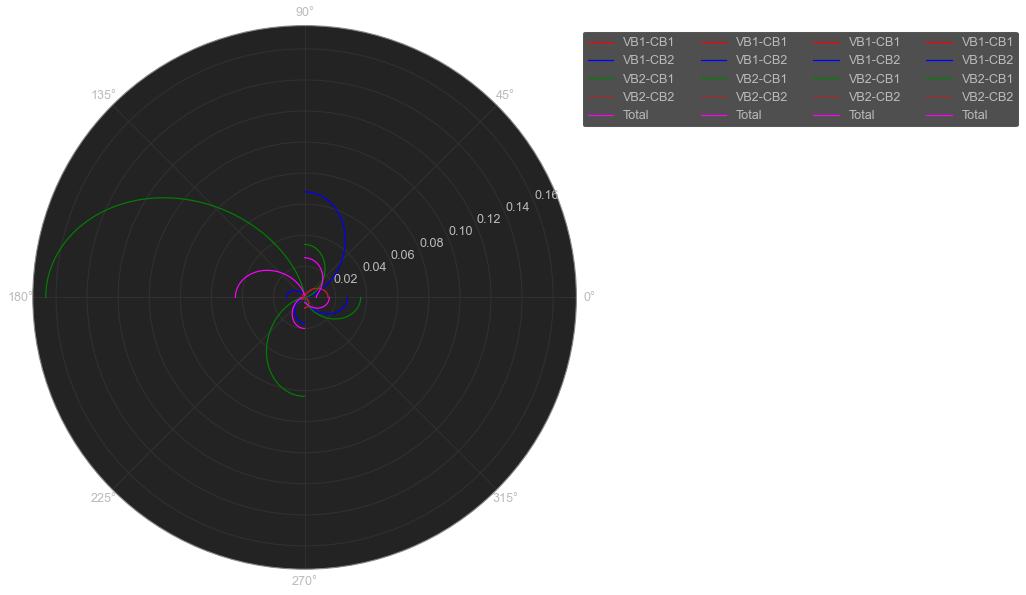

In [12]:
# Bands
bi = ["VB1", "VB2"]; bf = ["CB1", "CB2"]
# Default Values
me = 0.08; mh = 0.08; Pt = 4.7e-25; Pl = 3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
Eg = 2.3; Vcb = 0.4; Vvb = 1.5;
sim_properties = (sim_size, lat_size, Eg, (Pl, Pt))
band_list = list()
# Results
for b_i, b_f in product(bi, bf):
    print(b_i, b_f)
    qd1 = qbd.qd_results(qd_size, Vvb, mh, mh, b_i)
    qd2 = qbd.qd_results(qd_size, Vcb, me, me, b_f)
    band_list.append(ab.interband_transition_elements(qd1, qd2, sim_properties))

theta = np.linspace(0, np.pi/2, 100)
angular_elements = list()
trn = 3
plt.figure(figsize=(10,10))
ax = plt.subplot(projection="polar")
for t_i in range(trn+1):
    export_data = np.array(theta[:, np.newaxis])
    angular_elements = list()
    for b_i in band_list:
        trn_2 = np.sin(theta)**2*b_i[t_i][1][0]**2 + np.sin(theta)**2*b_i[t_i][1][1]**2 + np.cos(theta)**2*b_i[t_i][1][2]**2
        export_data = np.concatenate((export_data, trn_2[:, np.newaxis]), axis=1)
        angular_elements.append(trn_2)
    avg_trn = (angular_elements[0]+angular_elements[1]+angular_elements[2]+angular_elements[3])/4
    export_data = np.concatenate((export_data, avg_trn[:, np.newaxis]), axis=1)
    ax.plot(theta-np.pi*t_i/2, angular_elements[0], 'red', label="VB1-CB1")
    ax.plot(theta-np.pi*t_i/2, angular_elements[1], 'blue', label="VB1-CB2")
    ax.plot(theta-np.pi*t_i/2, angular_elements[2], 'green', label="VB2-CB1")
    ax.plot(theta-np.pi*t_i/2, angular_elements[3], 'brown', label="VB2-CB2")
    ax.plot(theta-np.pi*t_i/2, avg_trn, 'magenta', label="Total")
    df = pd.DataFrame(export_data, columns=["theta", "VB1-CB1", "VB1-CB2", "VB2-CB1", "VB2-CB2", "AVG"])
    df.to_csv(f"Angular_Band_Trn_{t_i}.csv", sep=" ", index=False)
plt.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=4)
plt.show()

## Testing Eg/V variation

In [3]:
def V_offset(Host_Eg, QD_Eg, offset_ratio):
    """ Return the adequately offseted Vcv/Vvb values """
    Vcb = (Host_Eg - QD_Eg)*offset_ratio
    Vvb = (Host_Eg - QD_Eg)*(1-offset_ratio)
    return Vcb, Vvb

Iteration 4000/4000


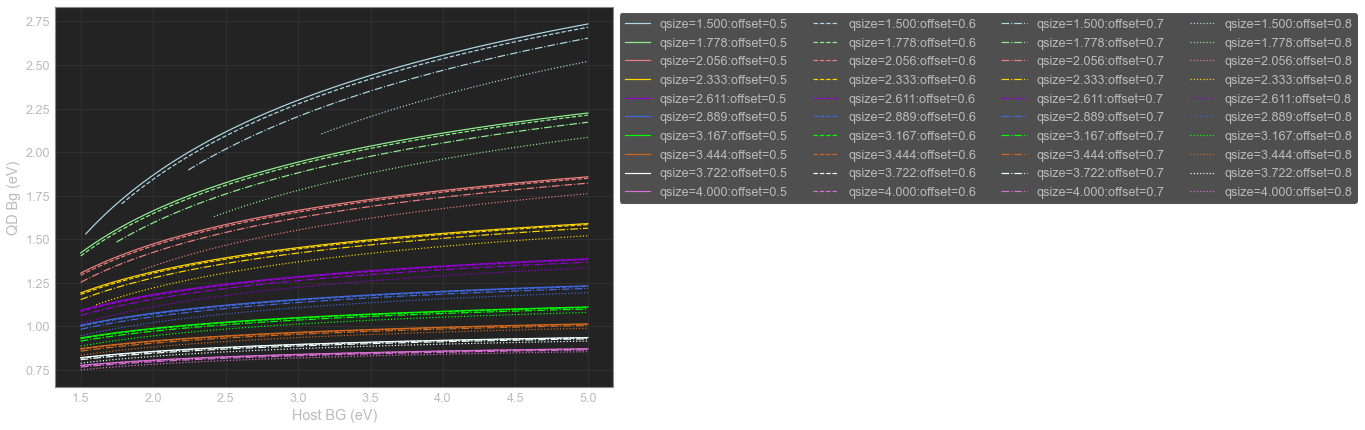

In [35]:
me=0.08; mh=0.08; Pt=4.7e-25; Pl=3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
run_i = 0
Eg = np.linspace(1.5, 5, 100)
qd_size = np.linspace(1.5, 4, 10)
band_i = "VB1"; band_f = "CB1"
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'darkviolet', 'royalblue', 'lime', 'chocolate', 'azure', 'orchid']
lt_list = ['-', '--', '-.', ':']
plt.figure(figsize=(10,7))
for lt, offset in enumerate([0.5, 0.6, 0.7, 0.8]):
    results = [list() for i in qd_size]
    Vcb, Vvb = V_offset(Eg, 0.4, offset)
    for result_i, qd_size_i in zip(results, qd_size):
        for Eg_i, Vcb_i, Vvb_i in zip(Eg, Vcb, Vvb):
            ## Calculate
            run_i+=1
            update_step(run_i, 4*10*100)
            qd1 = qbd.qd_results(qd_size_i, Vvb_i, mh, mh, band_i)
            qd2 = qbd.qd_results(qd_size_i, Vcb_i, me, me, band_f)
            try:
                trn = ab.interband_transition_elements(qd1, qd2, (sim_size, lat_size, Eg_i, (Pl, Pt)), count=1)[0][0]
            except IndexError:
                trn = np.nan
            result_i.append(trn)
        result_i = np.array(result_i)
        df = pd.DataFrame(result_i, columns=["QD_BG"], index=Eg)
        df["QD_Size"] = qd_size_i; df["Offset"] = offset
        df.to_csv(f"QD_BG_{qd_size_i:0.3f}_{offset}.csv", sep=" ", na_rep="NaN")
    ## Plot
    for i, qsize in enumerate(qd_size):
        plt.plot(Eg, results[i], colors[i], linestyle=lt_list[lt], label=f"{qsize=:0.3f}:{offset=}")

plt.xlabel("Host BG (eV)")
plt.ylabel("QD Bg (eV)")
plt.legend(bbox_to_anchor=(1,1), loc="upper left", ncol=4)

Iteration 2000/4000

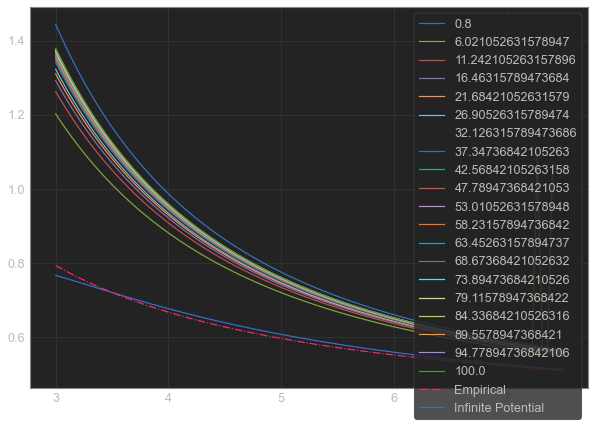

In [7]:
me=0.08; mh=0.08; Pt=4.7e-25; Pl=3.4e-25; qd_size = 3; lat_size = 0.8; sim_size = 15
run_i = 0
Eg = np.linspace(0.8, 100, 20)
qd_size = np.linspace(3, 7.5, 100)
band_i = "VB1"; band_f = "CB1"
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'darkviolet', 'royalblue', 'lime', 'chocolate', 'azure', 'orchid']
lt_list = ['-', '--', '-.', ':']
plt.figure(figsize=(10,7))
res_df = pd.DataFrame()
res_df["QSize"] = qd_size
for eg_i in Eg:
    Vcb, Vvb = V_offset(eg_i, 0.4, 0.5)
    results = []
    for qd_size_i in qd_size:
        ## Calculate
        run_i+=1
        update_step(run_i, 4*10*100)
        qd1 = qbd.qd_results(qd_size_i, Vvb, mh, mh, band_i)
        qd2 = qbd.qd_results(qd_size_i, Vcb, me, me, band_f)
        try:
            trn = ab.interband_transition_elements(qd1, qd2, (sim_size, lat_size, eg_i, (Pl, Pt)), count=1)[0][0]
        except IndexError:
            trn = np.nan
        results.append(trn)
    res_df[f"{eg_i=}"] = results
    plt.plot(qd_size, results, label=f"{eg_i}")
res_df.to_csv("QDEg_QSize.csv", sep=" ", index=False)
plt.plot(qd_size, 0.41+1/(0.0252*(2*qd_size)**2+0.283*(2*qd_size)), '-.', label="Empirical")
plt.plot(qd_size, 0.4 + 2*9.87/(26.26*0.08*qd_size**2), label="Infinite Potential")
plt.legend()
plt.show()

Code to perform a particle swarm optimization.
Essentialy there are 2 parts necessary:
- A dictionary with the several parameters (same name as defined in the function)
    - The should be defined as a list with the lower and upper bound for the parameters
- An optional dictionary with the some of the optional parameters
- The particle swarm function that does the actial optimization

In [ ]:
param_dict = {
    "qd_size": [1.5, 3],
    "me": [0.05, 0.15],
    "mh": [0.05, 0.15],
    "Pl": [1e-25, 1e-24],
    "Pt": [1e-25, 1e-24],
    "Eg": [1, 2.5],
    "offset": [0.2, 0.8]
}
const_args = {
    "energy": np.linspace(0.5, 4, 400),
    "lat_size": 0.65,
    "sim_size": 25
}
res = particle_swarm(ab.opt_function, param_dict,
                     n_particles=15, n_iter=30,
                     export=True, swarm_properties=(0.3, 1.5, 1.5),
                     **const_args)

In [ ]:
# Get all the parameters from the best optimization result
columns = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
data = pd.read_csv("PSO_Results/results_29", sep=" ", names=columns)
data.sort_values(by="FoM", ascending=False, ignore_index=True, inplace=True)
qsize, me, mh, Pl, Pt, Eg, offset, *_ = tuple(data.loc[0])
qd_cb = qbd.qd_results(qsize, (Eg - 0.4)*offset, me, me, band="CB1")
qd_vb = qbd.qd_results(qsize, (Eg - 0.4)*(1-offset), mh, mh, band="VB1")

sim_setup = (25, 0.65, Eg, (Pl, Pt))
qd1_prop = (qsize, (Eg - 0.4)*offset, me, me)
qd2_prop = (qsize, (Eg - 0.4)*(1-offset), mh, mh)
trn = ab.all_avg_trn_elements(qd1_prop, qd2_prop, sim_setup)
best_abs = ab.interband_absorption(np.linspace(0, 5, 600),qd1_prop, qd2_prop, sim_setup)

In [ ]:
ab._single_FoM(qsize, (Eg - 0.4)*offset, (Eg - 0.4)*(1-offset),
               me, mh, Pl, Pt, Eg, offset, sim_size=25, lat_size=0.65)

In [ ]:
qd_vb.e_levels

In [ ]:
qd_cb.e_levels

In [ ]:
# Plot the best optimization absorption profile
plt.figure(figsize=(10,8))
plt.plot(np.linspace(0, 5, 600), best_abs.iloc[:, 1:])
plt.xlabel("Absorption Coefficient", fontsize=18)
plt.ylabel("Energy (eV)", fontsize=18)
plt.tick_params(axis='both', labelsize=16)
plt.xlim(0, 3)
for index, (name, value) in enumerate(zip(columns, data.loc[0])):
    if index > 7:
        break
    plt.annotate(f"$\\bf{name}$={value:.3g}$\pm${value*0.05:.2f}", (0.02, 0.9-index/14), xycoords="axes fraction", fontsize=16)
plt.savefig("PSO_Best_2.svg", transparent=True)

In [ ]:
def pso_best_abs(it_name, energy=np.linspace(0.5, 4, 600), save=False, savename="PSO_Best_2.svg"):
    """ Plot the best optimization result """
    # Get all the parameters from the best optimization result
    columns = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
    data = pd.read_csv(it_name, sep=" ", names=columns)
    data.sort_values(by="FoM", ascending=False, ignore_index=True, inplace=True)
    # Unpack into the several variables
    qsize, me, mh, Pl, Pt, Eg, offset, *_ = tuple(data.loc[0])
    # Contruct the best qds and properties
    sim_setup = (25, 0.65, Eg, (Pl, Pt))
    qd1_prop = (qsize, (Eg - 0.4)*offset, me, me)
    qd2_prop = (qsize, (Eg - 0.4)*(1-offset), mh, mh)
    # Calculate the best properties
    trn = ab.all_avg_trn_elements(qd1_prop, qd2_prop, sim_setup)
    best_abs = ab.interband_absorption(energy, qd1_prop, qd2_prop, sim_setup)
    # Plot the best optimization absorption profile
    plt.figure(figsize=(10,8))
    plt.plot(energy, best_abs.iloc[:, 1:])
    plt.xlabel("Absorption Coefficient", fontsize=18)
    plt.ylabel("Energy (eV)", fontsize=18)
    plt.tick_params(axis='both', labelsize=16)
    plt.xlim(0, 3)
    for index, (name, value) in enumerate(zip(columns, data.loc[0])):
        if index > 7:
            break
        plt.annotate(f"$\\bf{name}$={value:.3g}$\pm${value*0.05:.2f}", (0.02, 0.9-index/14), xycoords="axes fraction", fontsize=16)
    if save:
        plt.savefig(savename, transparent=True)

Function to facilitate the visualization of optimization results.
Essentially it grabs the the file results and then creates the plots
```python
def pso_it_energy_profile(ax, it_name, save=False, savename="Band_diagrams.svg"):
    """
    Utility function to grab the data for all the particles in a iteration
    and then create a profile of the energy levels for each particle
    Args:
        ax: list with the axes (obtained from plt.subplots)
        it_name: name for the particular iteration
        save: wether to save the file
        savename: Name to save the file
    """
    # Columns for the optimization
    columns = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
    data = pd.read_csv(it_name, sep=" ", names=columns)
    ordered_data = data.apply(tuple, axis=1).values.reshape(ax.shape)
    # Normalized x to organize the standar information
    x = np.linspace(0, 1, 50)
    for i, line in enumerate(ordered_data):
        for j, column in enumerate(line):
            Vcb = (column[5] - 0.4)*column[6]
            Vvb = (column[5] - 0.4)*(1-column[6])
            qd_cb = qbd.qd_results(column[0], Vcb, column[1], column[1], band="CB1")
            qd_vb = qbd.qd_results(data_i[0], Vvb, column[2], column[2], band="VB1")
            # Define plot limits
            ax[i, j].set_ylim(0, column[5])
            ax[i, j].spines['right'].set_visible(False)
            ax[i, j].spines['top'].set_visible(False)
            ax[i, j].spines['bottom'].set_visible(False)
            # Create the band diagram from Eg, Vcb, Vvb
            # Left/Righ sides of the bands
            ax[i, j].axhline(0, xmin=0, xmax=0.25, color="k")
            ax[i, j].axhline(column[5], xmin=0, xmax=0.25, color="k")
            ax[i, j].axhline(0, xmin=0.65, xmax=1, color="k")
            ax[i, j].axhline(column[5], xmin=0.65, xmax=1, color="k")
            # Mid Line
            ax[i, j].axhline(Vvb, xmin=0.25, xmax=0.65, color="k")
            ax[i, j].axhline(Vvb+0.4, xmin=0.25, xmax=0.65, color="k")
            # Add vertical bariers
            ax[i, j].axvline(0.25, ymin=0, ymax=Vvb/column[5], color="k")
            ax[i, j].axvline(0.65, ymin=0, ymax=Vvb/column[5], color="k")
            ax[i, j].axvline(0.25, ymin=(Vvb+0.4)/column[5], ymax=1, color="k")
            ax[i, j].axvline(0.65, ymin=(Vvb+0.4)/column[5], ymax=1, color="k")
            ax[i, j].set_xticks(ticks=[])
            ax[i, j].tick_params(axis="y", labelsize=16)
            # Plot the energy spectrum (from -0.25 to 0.25)
            for e_cb in qd_cb.e_levels.values.flatten():
                ax[i, j].axhline(column[5] + e_cb, xmin=0.25, xmax=0.65)
            for e_vb in qd_vb.e_levels.values.flatten():
                ax[i, j].axhline(-e_vb, xmin=0.25, xmax=0.65)
    if save:
        plt.savefig(savename, transparent=True)
```

Function to facilitate the visualization of the absorption profiles for a particular optimization iteration
```python
def pso_it_abs_preview(ax, it_name, energy=np.linspace(0.4, 3, 600), save=False):
    """ Import data from a particular PSO optimization and plot the absorption for all particles """
    columns = ["QSize", "me", "mh", "Pl", "Pt", "Eg", "offset", "FoM", "vQSize", "vme", "vmh", "vPl", "vPt", "vEg", "voffset"]
    data = pd.read_csv(it_name, sep=" ", names=columns)
    results = []
    # Import the data all the info to a list of Dataframes with the severall absorptions
    for data_i in data.apply(tuple, axis=1):
        Vcb = (data_i[5] - 0.4)*data_i[6]
        Vvb = (data_i[5] - 0.4)*(1-data_i[6])
        qd_cb = (data_i[0], Vcb, data_i[1], data_i[1])
        qd_vb = (data_i[0], Vvb, data_i[2], data_i[2])
        sim_properties = (15, 0.65, data_i[5], (data_i[3], data_i[4]))
        results.append(ab.interband_absorption(energy, qd_cb, qd_vb, sim_properties))
    # Create the array with the flat indexes
    flat_index = np.arange(0, np.prod(ax.shape)).reshape(ax.shape)
    for i in range(ax.shape[0]):
        for k in range(ax.shape[1]):
            ax[i, k].plot(results[0]["Energy"], results[flat_index[i, k]]["Total"])
            ax[i, k].set_title(f"FoM={data['FoM'][flat_index[i, k]]:.2f}", fontsize=18)
            ax[i, k].tick_params(labelsize=14)
            if k == 0:
                ax[i, k].set_ylabel("Absorption Coef (nm$^3$/cm)", fontsize=16)
            if i == 2:
                ax[i, k].set_xlabel("Energy (eV)", fontsize=16)
    if save:
        plt.savefig("Absorption_Coefs.svg", transparent=True)
 ```

In [ ]:
# Run to see the optimization results
fig, ax = plt.subplots(3, 5, figsize=(20,13))
utils.pso_it_energy_profile(ax, "PSO_Results/results_29")
fig, ax = plt.subplots(3, 5, figsize=(20,13))
pso_it_abs_preview("PSO_Results/results_29")